In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import seaborn as sns
from sklearn.metrics import accuracy_score
import sklearn
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder


In [21]:
with open('sign_data/asl-signs/sign_to_prediction_index_map.json') as f: 
    sign_map = json.load(f)

def mapping_sign_code(sign: str):
    return sign_map[sign]

signs = list(sign_map)
train = pd.read_csv('sign_data/asl-signs/train.csv')
train['sign_code'] = train['sign'].apply(mapping_sign_code)


In [22]:
# Instantiate the encoder
le = LabelEncoder()

# Fit the encoder and transform the 'sign' column
train['sign_code'] = le.fit_transform(train['sign'])

# Create dictionaries for mapping
SIGN2ORD = dict(zip(le.classes_, le.transform(le.classes_)))
ORD2SIGN = dict(zip(le.transform(le.classes_), le.classes_))

In [88]:
train

,path,participant_id,sequence_id,sign,sign_code
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164
...,...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white,238
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have,108
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower,86
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room,188


In [23]:
# Label
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

In [7]:
NUM_CLASSES = 250

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu
BATCH_ALL_SIGNS_N = 3
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)

In [8]:
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

In [12]:
# Load Test
BASE_DIR = 'data'
X_test = np.load(f'{BASE_DIR}/X_test.npy')
y_test = np.load(f'{BASE_DIR}/y_test.npy')
NON_EMPTY_FRAME_IDXS_TEST = np.load(f'{BASE_DIR}/NON_EMPTY_FRAME_IDXS_TEST.npy')

In [92]:
len(X_test[0])


64

In [10]:
custom_objects = {
    'scce_with_ls': scce_with_ls
}

transformer_model = tf.keras.models.load_model("OneDrive_1_20-08-2023/full_transformer_model", custom_objects=custom_objects)
lstm_model = tf.keras.models.load_model("OneDrive_1_20-08-2023/full_lstm_model", custom_objects=custom_objects)


In [50]:
def print_classification_report(model_pred):
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_test,
            model_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        # classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

    
    return classification_report


In [75]:
# Transformer Test Predictions
transformer_y_pred = transformer_model.predict({'frames' : X_test,'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST }, verbose=2).argmax(axis=1)
accuracy = accuracy_score(y_test, transformer_y_pred)
print(f"Transformer Test Accuracy: {accuracy:.4f}")

398/398 - 216s - 216s/epoch - 544ms/step
Transformer Test Accuracy: 0.5799


In [15]:
#LSTM Test Predictions
lstm_y_pred = lstm_model.predict({'frames' : X_test,'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST }, verbose=2).argmax(axis=1)
accuracy = accuracy_score(y_test, lstm_y_pred)
print(f"LSTM Test Accuracy: {accuracy:.4f}")

398/398 - 141s - 141s/epoch - 354ms/step
LSTM Test Accuracy: 0.5031


In [76]:
transformer_classification_report = print_classification_report(transformer_y_pred)
lstm_classification_report = print_classification_report(lstm_y_pred)

,precision,recall,f1-score,support,sign,sign_ord
water,0.95,0.93,0.94,56,water,234
nose,0.92,0.87,0.90,55,nose,155
drink,0.94,0.85,0.90,55,drink,63
bug,0.95,0.79,0.86,52,bug,32
gum,0.81,0.89,0.85,56,gum,103
owl,0.95,0.76,0.85,51,owl,165
horse,0.90,0.81,0.85,54,horse,119
flower,1.00,0.72,0.84,54,flower,86
airplane,0.86,0.82,0.84,51,airplane,2
stuck,0.91,0.78,0.84,51,stuck,209


,precision,recall,f1-score,support,sign,sign_ord
shhh,0.94,0.88,0.91,57,shhh,194
nose,0.98,0.80,0.88,55,nose,155
water,0.92,0.80,0.86,56,water,234
airplane,0.93,0.76,0.84,51,airplane,2
gum,0.84,0.82,0.83,56,gum,103
drink,0.93,0.73,0.82,55,drink,63
horse,0.91,0.74,0.82,54,horse,119
chocolate,0.75,0.87,0.81,53,chocolate,44
owl,0.97,0.69,0.80,51,owl,165
stuck,0.85,0.76,0.80,51,stuck,209


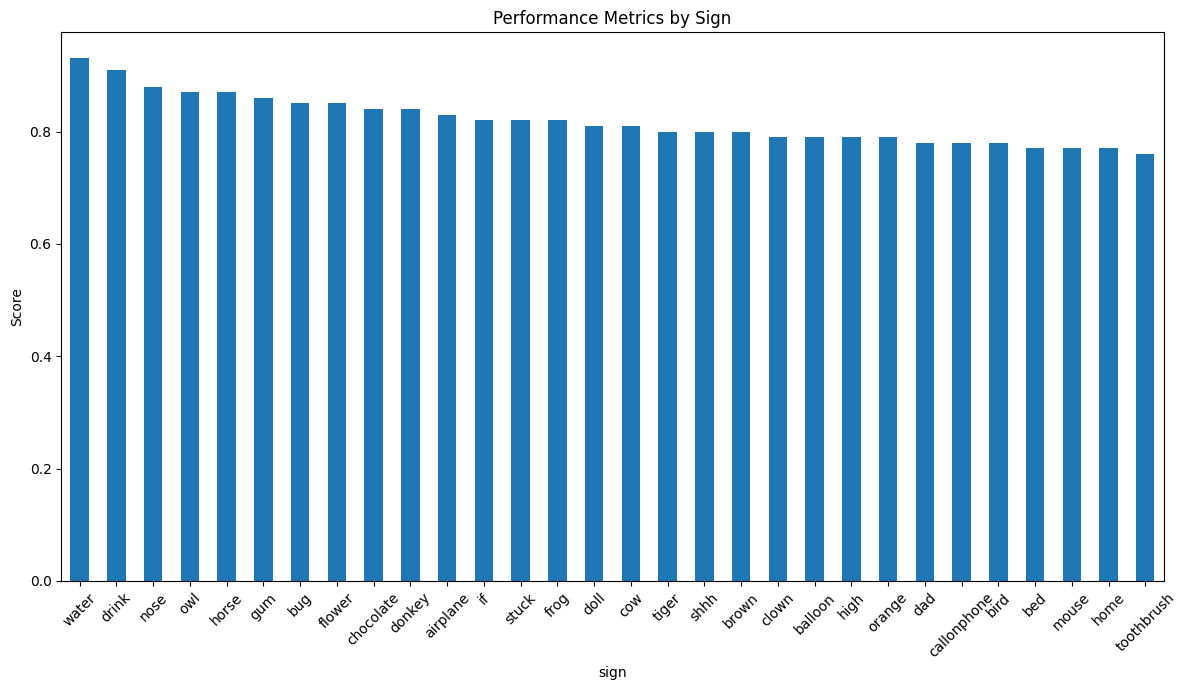

In [27]:
# Assuming df is your dataframe
transformer_classification_report.set_index('sign')['f1-score'][:30].plot(kind='bar', figsize=(12,7))
plt.ylabel('Score')
plt.title('Performance Metrics by Sign')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


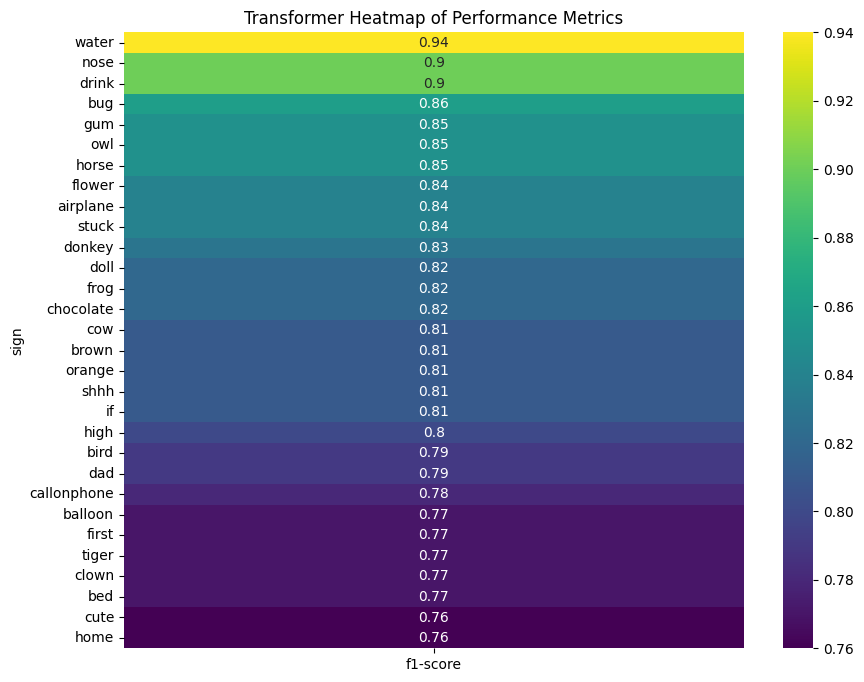

In [83]:
plt.figure(figsize=(10,8))
sns.heatmap(transformer_classification_report.set_index('sign')[['f1-score']][:30], annot=True, cmap='viridis')
plt.title('Transformer Heatmap of Performance Metrics')
plt.show()


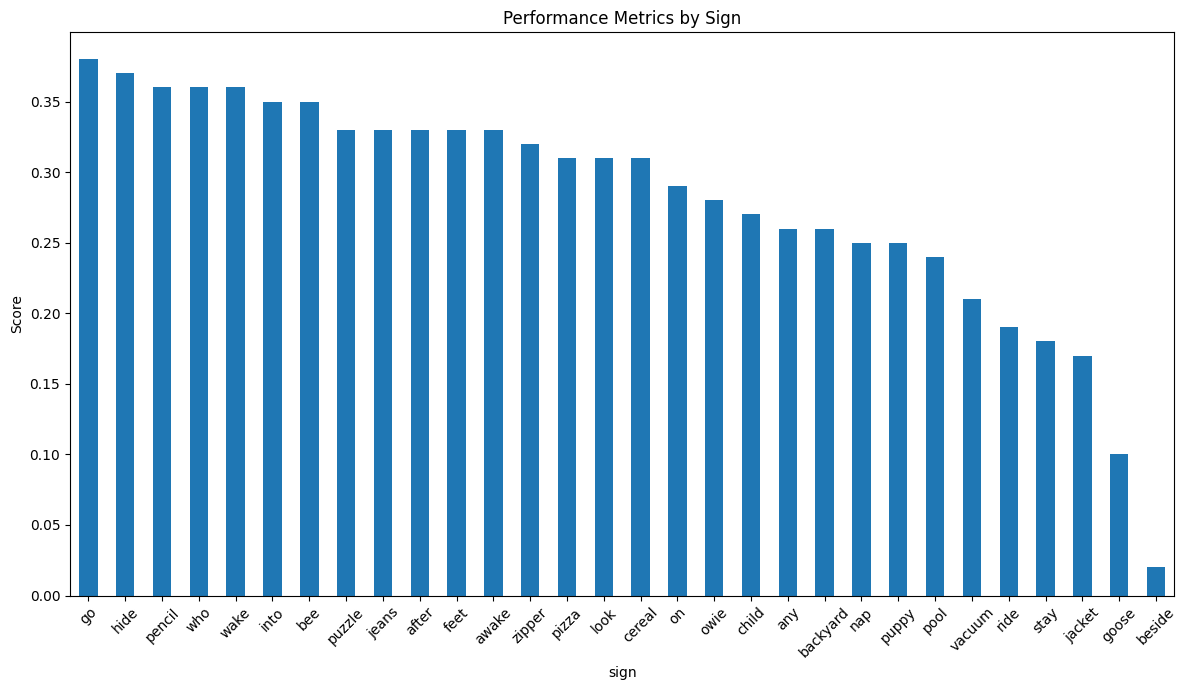

In [31]:
transformer_classification_report.set_index('sign')['f1-score'][-30:].plot(kind='bar', figsize=(12,7))
plt.ylabel('Score')
plt.title('Performance Metrics by Sign')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

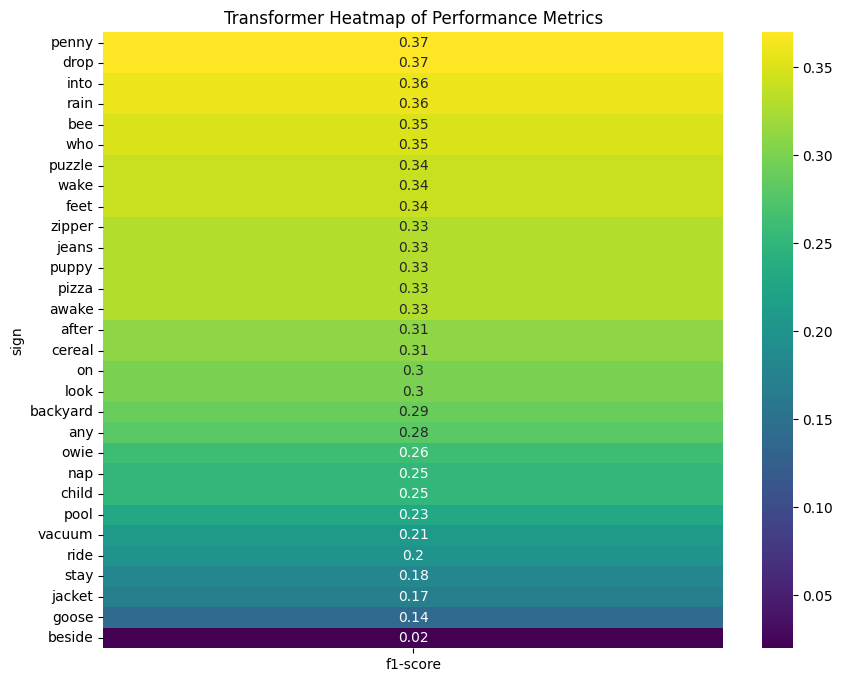

In [84]:
plt.figure(figsize=(10,8))
sns.heatmap(transformer_classification_report.set_index('sign')[['f1-score']][-30:], annot=True, cmap='viridis')
plt.title('Transformer Heatmap of Performance Metrics')
plt.show()


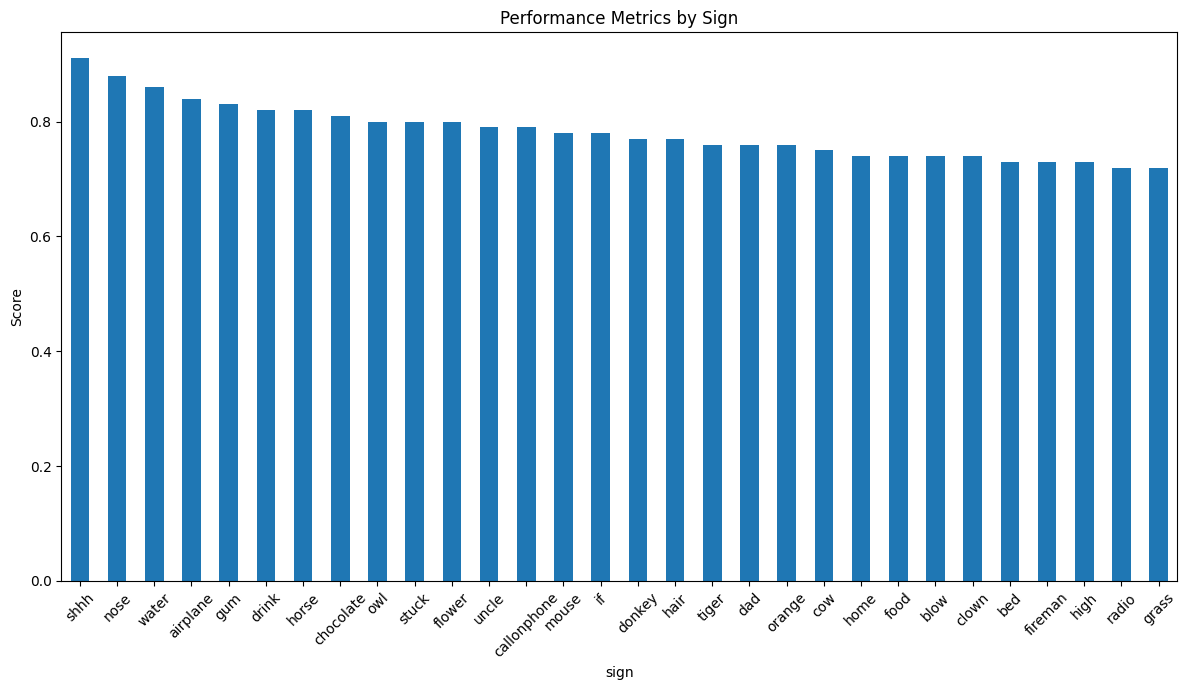

In [28]:
lstm_classification_report.set_index('sign')['f1-score'][:30].plot(kind='bar', figsize=(12,7))
plt.ylabel('Score')
plt.title('Performance Metrics by Sign')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

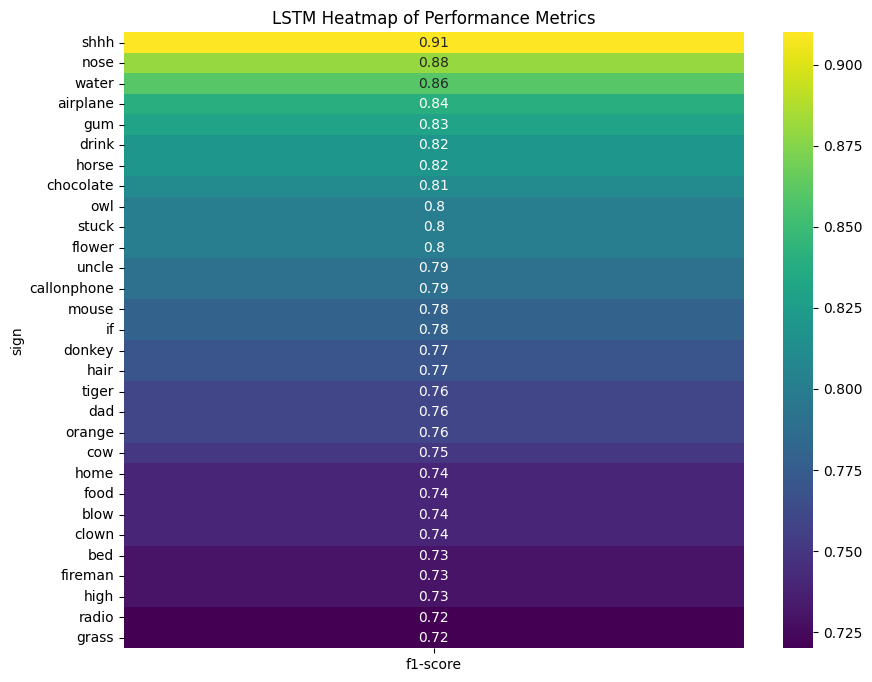

In [85]:
plt.figure(figsize=(10,8))
sns.heatmap(lstm_classification_report.set_index('sign')[['f1-score']][:30], annot=True, cmap='viridis')
plt.title('LSTM Heatmap of Performance Metrics')
plt.show()

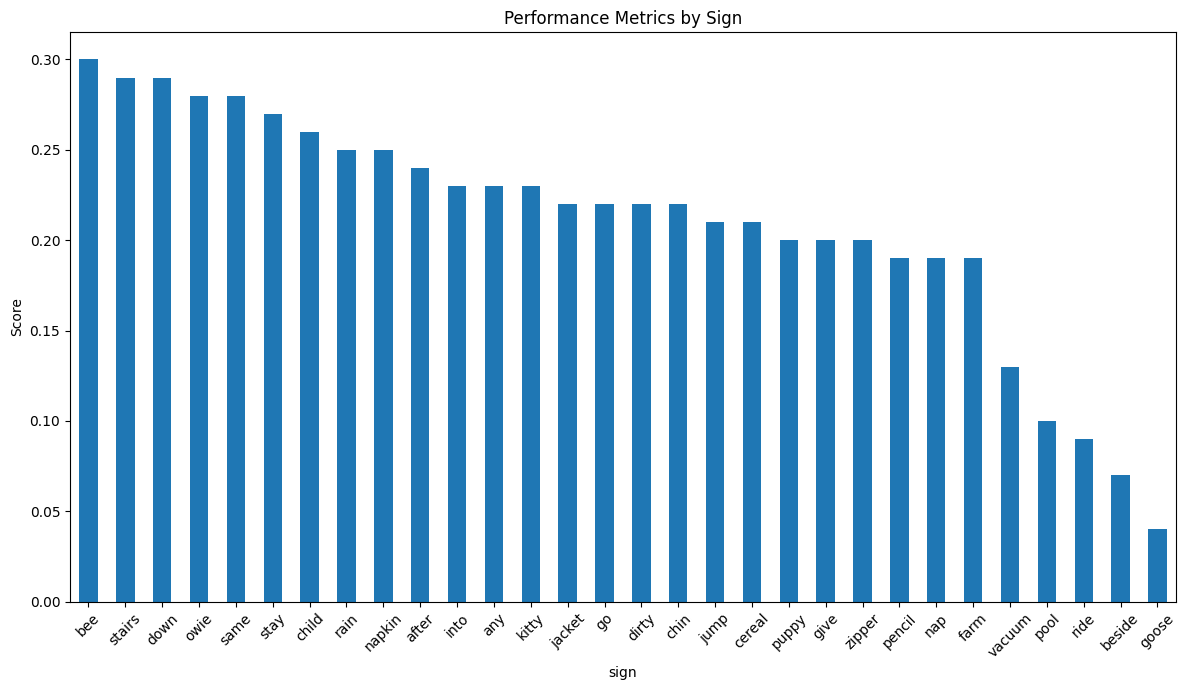

In [34]:
lstm_classification_report.set_index('sign')['f1-score'][-30:].plot(kind='bar', figsize=(12,7))
plt.ylabel('Score')
plt.title('Performance Metrics by Sign')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

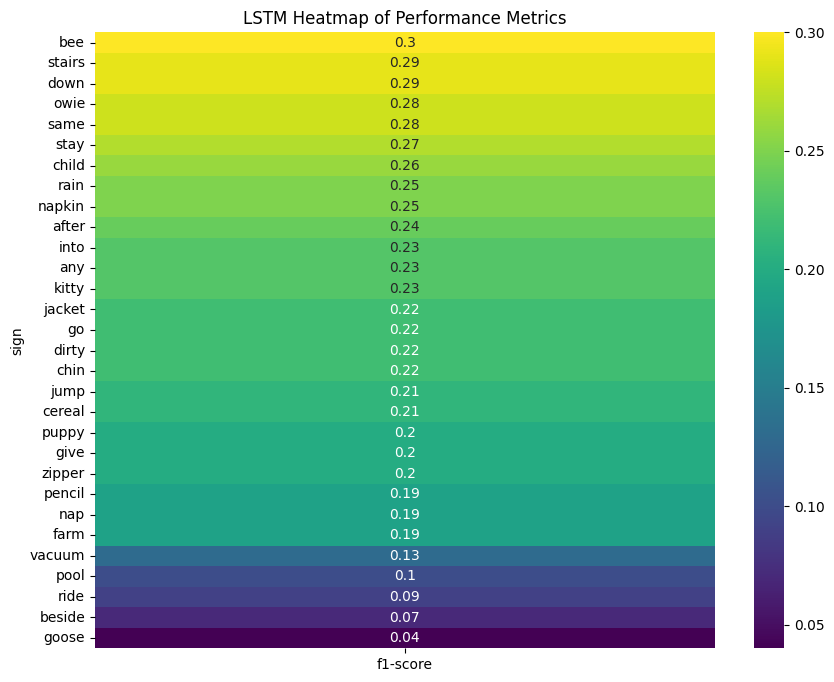

In [86]:
plt.figure(figsize=(10,8))
sns.heatmap(lstm_classification_report.set_index('sign')[['f1-score']][-30:], annot=True, cmap='viridis')
plt.title('LSTM Heatmap of Performance Metrics')
plt.show()


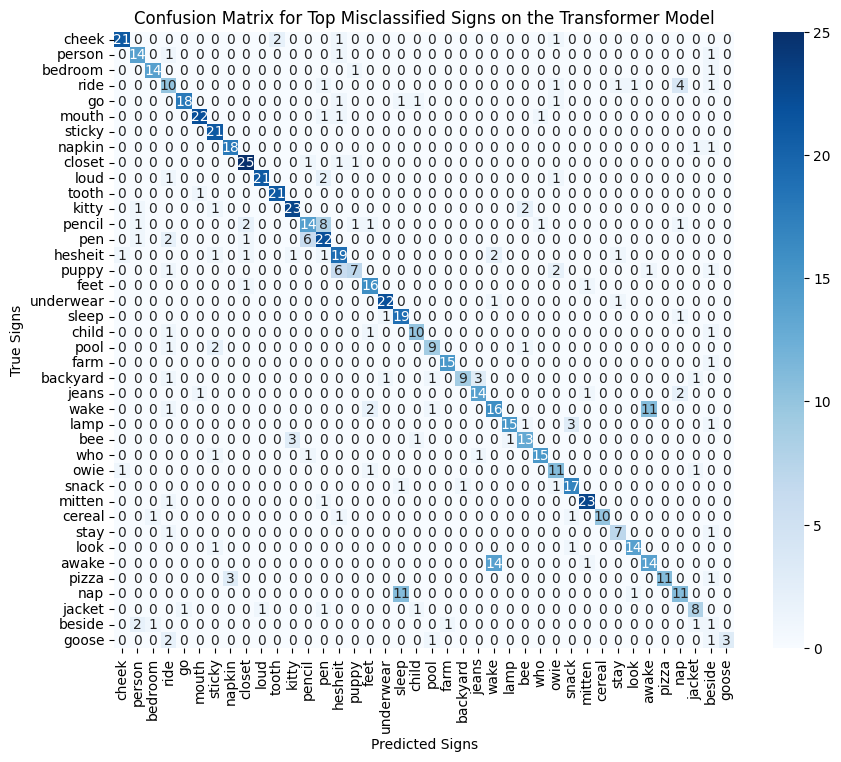

In [38]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = transformer_y_pred
unique_ordinals = list(ORD2SIGN.keys())
unique_signs = list(ORD2SIGN.values())
cm = confusion_matrix(y_true, y_pred,labels=unique_ordinals)

# Step 1: Sum the off-diagonal elements

off_diagonal_sums = cm.sum(axis=1) - np.diag(cm)

# Step 2: Select top N misclassified classes
N = 40  # or any number you're interested in
top_N_indices = np.argsort(off_diagonal_sums)[-N:]

# Step 3: Create a reduced confusion matrix
reduced_cm = cm[np.ix_(top_N_indices, top_N_indices)]
reduced_signs = [unique_signs[i] for i in top_N_indices]

# Step 4: Plot the reduced confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(reduced_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=reduced_signs, yticklabels=reduced_signs)
plt.xlabel('Predicted Signs')
plt.ylabel('True Signs')
plt.title('Confusion Matrix for Top Misclassified Signs on the Transformer Model')
plt.show()


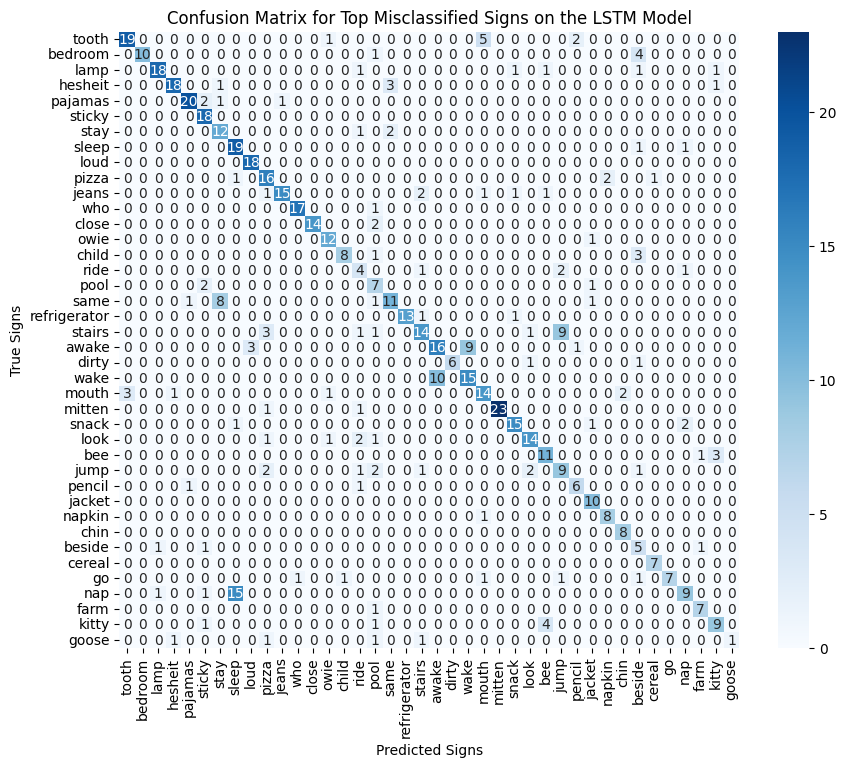

In [39]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = lstm_y_pred
unique_ordinals = list(ORD2SIGN.keys())
unique_signs = list(ORD2SIGN.values())
cm = confusion_matrix(y_true, y_pred,labels=unique_ordinals)

# Step 1: Sum the off-diagonal elements

off_diagonal_sums = cm.sum(axis=1) - np.diag(cm)

# Step 2: Select top N misclassified classes
N = 40  # or any number you're interested in
top_N_indices = np.argsort(off_diagonal_sums)[-N:]

# Step 3: Create a reduced confusion matrix
reduced_cm = cm[np.ix_(top_N_indices, top_N_indices)]
reduced_signs = [unique_signs[i] for i in top_N_indices]

# Step 4: Plot the reduced confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(reduced_cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=reduced_signs, yticklabels=reduced_signs)
plt.xlabel('Predicted Signs')
plt.ylabel('True Signs')
plt.title('Confusion Matrix for Top Misclassified Signs on the LSTM Model')
plt.show()
